# Pytorch- MNIST

利用pytorch建立神經網路  
[torch document](https://pytorch.org/docs/stable/index.html)  
[中文文檔](https://pytorch-cn.readthedocs.io/zh/latest/)

## Import module 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import time

## torch dataset

[reference](https://zhuanlan.zhihu.com/p/30934236)
torch dataset為以下的關係
dataset -> DataLoader -> DataLoaderiter
### dataset:
為自訂義的資料集，這裡直接取用torch內建的MNIST  
若需要自訂義，需要重載__len__與__getitem__  
而dataset可以自訂義transform，此為熟悉的data augumentation，一般重要的把數據集轉為tensor與normalize都在這裡apply  
normalize的內容為(mean,std)  
  
### dataloader:
將資料封入容器內，在訓練時的forloop會調用__iter__來輸出資料  
具體常定義內容為: batchsize, shuffle(打散資料)


MNIST資料集在pytorch 內建的可以直接下載利用，利用train flag來決定下載的是訓練集或是測試集資料  
由於缺少validation set，利用torch內建的random_split來切割訓練與驗證集  
這裡只是粗略分類，一個較好的分類方法是最好將兩組資料的比例做良好的分布  
scipy的train_test_split可以利用stratify來做分類依據

In [2]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5,), (1.0,))])


train_set = datasets.MNIST(root='./train', train=True, transform=trans)
test_set = datasets.MNIST(root='./test', train=False, transform=trans)

train_size = int(0.8 * len(train_set))
val_size = len(train_set) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_set, [train_size, val_size])

In [3]:
batch_size = 128

train_loader = DataLoader(
                 dataset=train_dataset,
                 batch_size=batch_size,
                 shuffle=True)

val_loader = DataLoader(
                 dataset=val_dataset,
                 batch_size=batch_size,
                 shuffle=True)

test_loader = DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)

In [4]:
print(type(train_set),'\n',type(train_dataset),'\n',type(train_loader),'\n' )
print(len(train_loader))

<class 'torchvision.datasets.mnist.MNIST'> 
 <class 'torch.utils.data.dataset.Subset'> 
 <class 'torch.utils.data.dataloader.DataLoader'> 

375


### try to plot content
每一組Dataset打包成一組pair  
其內容為[第N組][0=data,1=label]  
而data為channel first

torch.Size([10000, 28, 28])


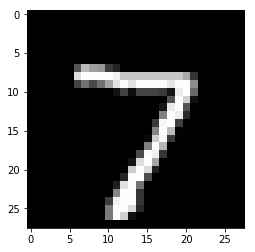

In [17]:
print(test_set.data.shape)
plt.imshow(test_set.data[0].numpy(),cmap='gray')

In [6]:
torch.cuda.is_available()

True

## 搭建CNN網路
torch網路搭建利用繼承nn.Module  
並在內部繼承__init__，並自訂義需要的unit  
最後重載forward，在這裡架設網路與定義輸出 
  
另外也一併定義梯度下降的learning rate與method  
這裡利用Adam  

loss function則選用cross_entropy  
pytorch的CE內部運算等同經由了log_softmax和nll_loss  
也就是外部的label可以不用轉成onehot的形式，直接用scaler即可  
[reference](https://www.cnblogs.com/marsggbo/p/10401215.html)

由於比較習慣看keras的summary  
https://github.com/sksq96/pytorch-summary  
此github提供了不錯的模組來讓pytorch也可以如keras輸出model summary  

In [7]:
class CNN(nn.Module):
    def __init__(self,input_dim=(28,28),channel=1):
        super(CNN, self).__init__()
        self.input_dim = input_dim
        self.channel = channel
        self.fc1 = nn.Linear(7*7*25, 100)
        self.fc2 = nn.Linear(100, 10)
        
        def convlayer(n_input, n_output, k_size=3, stride=1, padding=1):
            block = [
                nn.Conv2d(n_input, n_output, k_size, stride, padding),
                nn.BatchNorm2d(n_output),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(2)
            ]
            return block

        self.conv = nn.Sequential(
            *convlayer(1, 25, 3, 1, 1),
            *convlayer(25, 25, 3, 1, 1),
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # PyTorch v0.4.0
device = torch.device("cuda") # PyTorch v0.4.0
cnn = CNN().to(device)

optimizer = optim.Adam(cnn.parameters(), lr=0.001)
loss_func = nn.CrossEntropyLoss()

summary(cnn, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 25, 28, 28]             250
       BatchNorm2d-2           [-1, 25, 28, 28]              50
              ReLU-3           [-1, 25, 28, 28]               0
         MaxPool2d-4           [-1, 25, 14, 14]               0
            Conv2d-5           [-1, 25, 14, 14]           5,650
       BatchNorm2d-6           [-1, 25, 14, 14]              50
              ReLU-7           [-1, 25, 14, 14]               0
         MaxPool2d-8             [-1, 25, 7, 7]               0
            Linear-9                  [-1, 100]         122,600
           Linear-10                   [-1, 10]           1,010
Total params: 129,610
Trainable params: 129,610
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.61
Params size (MB): 0.49
Estimated T

## 訓練模型
模型的訓練的步驟為:
1. 利用一forloop把Dataloader的資料以批次的方式輸出
2. 讓data經由定義的網路輸出後與target計算loss function
3. 對loss function做反向傳播運算(這裡即是對網路的weight梯度運算)
4. optimizer.step()此即為更新權重

可以自訂義Accuracy與把loss記錄下來作為模型訓練的評估



[backward_ref1](https://blog.csdn.net/douhaoexia/article/details/78821428)  
[backward_ref2](http://www.linzehui.me/2018/09/16/%E7%A2%8E%E7%89%87%E7%9F%A5%E8%AF%86/Pytorch%20backward()%E6%B5%85%E6%9E%90/)

In [8]:
epochs = 20
train_loss_history=[]
train_acc_history=[]
val_loss_history=[]
val_acc_history=[]

for epoch in range(epochs):
    # === training ==== 
    cnn.train()
    tStart = time.time()
    correct_train = 0
    total_train = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        data, target = data.to(device) , target.to(device)
        output = cnn(data)
        loss=loss_func(output, target)
        loss.backward()
        optimizer.step()
        predicted = torch.max(output.data, 1)[1]
        total_train += len(target)
        correct_train += (predicted == target).float().sum()
        if batch_idx+1 == len(train_loader) :
            train_loss_history.append(loss.data)
    train_acc_history.append(correct_train/total_train)

    
    # === validation ====
    cnn.eval()
    tStart = time.time()
    correct_val = 0
    total_val = 0
    for batch_idx, (data, target) in enumerate(val_loader):
        data, target = data.to(device) , target.to(device)
        output = cnn(data)
        loss = loss_func(output, target)
        predicted = torch.max(output.data, 1)[1]
        total_val += len(target)
        correct_val += (predicted == target).float().sum()
        if batch_idx+1 == len(val_loader) :
            val_loss_history.append(loss.data)
    val_acc_history.append(correct_val/total_val)

    print('Train Epoch: {} train_acc: {:.4f}, train_Loss: {:.4f}|val_acc: {:.4f}, val_loss: {:.4f},  usage time: {:.2f}s'
          .format(epoch, train_acc_history[epoch], train_loss_history[epoch],
        val_acc_history[epoch], val_loss_history[epoch], time.time()-tStart))

Train Epoch: 0 train_acc: 0.9484, train_Loss: 0.0573|val_acc: 0.9815, val_loss: 0.0442,  usage time: 1.56s
Train Epoch: 1 train_acc: 0.9829, train_Loss: 0.0409|val_acc: 0.9807, val_loss: 0.0848,  usage time: 1.52s
Train Epoch: 2 train_acc: 0.9875, train_Loss: 0.0327|val_acc: 0.9828, val_loss: 0.0104,  usage time: 1.51s
Train Epoch: 3 train_acc: 0.9896, train_Loss: 0.0723|val_acc: 0.9862, val_loss: 0.0171,  usage time: 1.52s
Train Epoch: 4 train_acc: 0.9918, train_Loss: 0.0193|val_acc: 0.9887, val_loss: 0.0026,  usage time: 1.52s
Train Epoch: 5 train_acc: 0.9936, train_Loss: 0.0397|val_acc: 0.9891, val_loss: 0.0199,  usage time: 1.51s
Train Epoch: 6 train_acc: 0.9948, train_Loss: 0.0078|val_acc: 0.9886, val_loss: 0.0152,  usage time: 1.56s
Train Epoch: 7 train_acc: 0.9957, train_Loss: 0.0261|val_acc: 0.9883, val_loss: 0.0103,  usage time: 1.52s
Train Epoch: 8 train_acc: 0.9952, train_Loss: 0.0175|val_acc: 0.9887, val_loss: 0.0066,  usage time: 1.49s
Train Epoch: 9 train_acc: 0.9962, tra

## 評估模型
對於模型的評估  
觀察loss function是很重要的，利用validation set可以判斷是否過擬和

(<matplotlib.legend.Legend at 0x20492f18f98>, Text(0.5, 1.0, 'loss'))

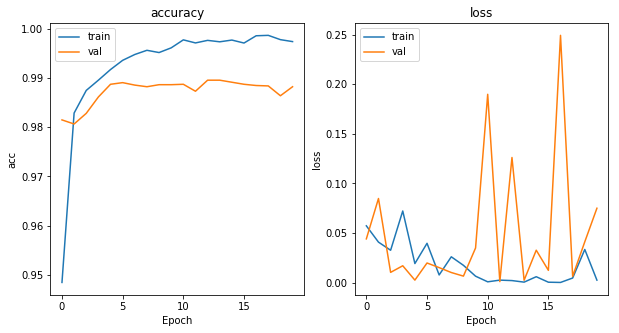

In [9]:
plt.figure(figsize=(10,5))
ax1 =plt.subplot(1,2,1)
ax1.plot(np.arange(20),train_acc_history,label='train')
ax1.plot(np.arange(20),val_acc_history,label='val')
plt.xlabel('Epoch'),plt.ylabel('acc')
plt.legend(),plt.title('accuracy')

ax2 =plt.subplot(1,2,2)
ax2.plot(np.arange(20),train_loss_history,label='train')
ax2.plot(np.arange(20),val_loss_history,label='val')
plt.xlabel('Epoch'),plt.ylabel('loss')
plt.legend(),plt.title('loss')

## Test set評估模型
validation set作為模型的選擇會有偏好存在  
必須利用test set作為模型成效評估  
另外提取其中一組data來可視化輸出看看模型的結果  

test_accuray: 99.00%


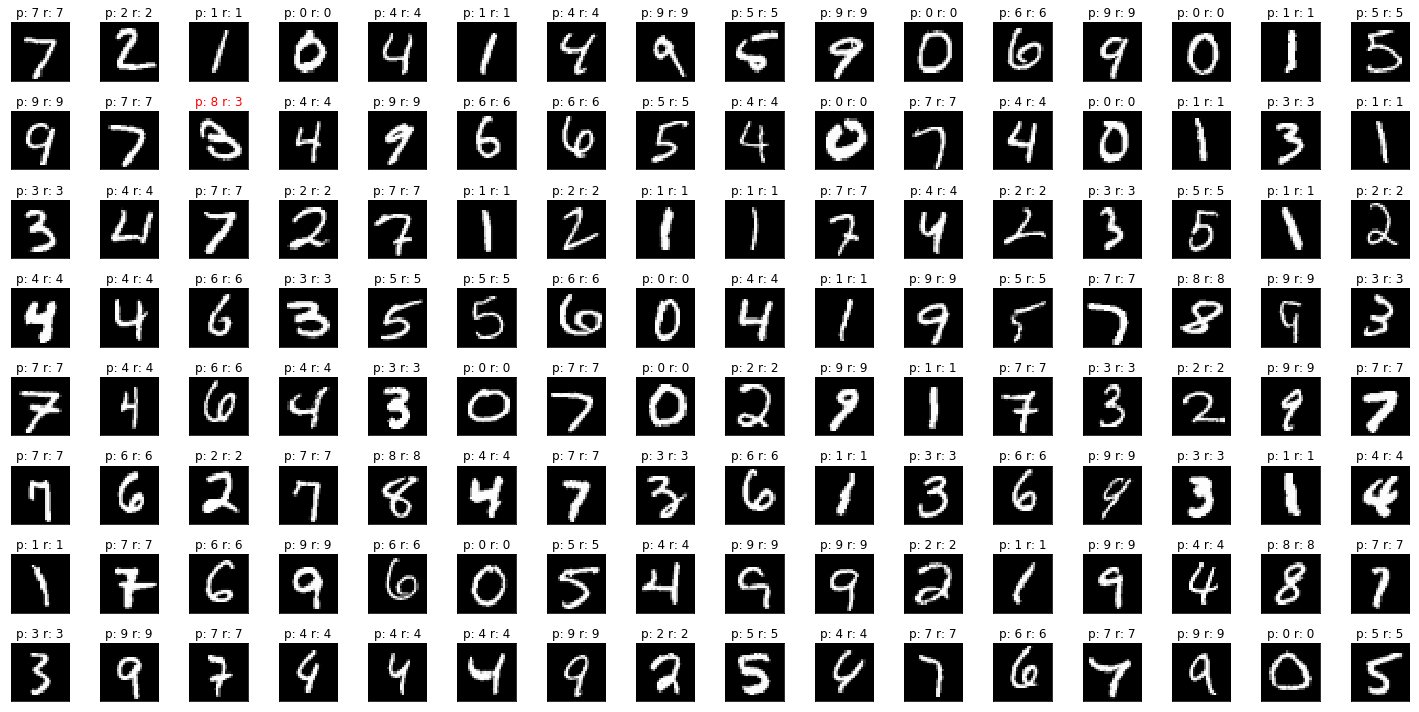

In [11]:
total_test=0
correct_test=0
for batch_idx, (data, target) in enumerate(test_loader):
    data_c, target_c = data.to(device) , target.to(device)
    output = cnn(data_c)
    predicted = torch.max(output.data, 1)[1]
    total_test += len(target_c)
    correct_test += (predicted == target_c).float().sum()
    if batch_idx == 0:
        plt.figure(figsize=(20,10))
        p_cpu=predicted.cpu()
        for idx in range(128):
            plt.subplot(8,16,idx+1),plt.imshow(data.numpy()[idx][0],cmap='gray')
            p , r  = str(p_cpu.data[idx].numpy()), str(target.data[idx].numpy())
            if p == r:
                plt.title('p: '+ str(p_cpu.data[idx].numpy())+' r: '+ str(target.data[idx].numpy()))
            else:
                plt.title('p: '+ str(p_cpu.data[idx].numpy())+' r: '+ str(target.data[idx].numpy()),color='red')
            plt.xticks([]),plt.yticks([])
        plt.tight_layout()

print( 'test_accuray: {:.2f}%'.format( 100*correct_test/total_test))

## 儲存model

torch儲存model  
與儲存weight的方法

In [12]:
torch.save(cnn, 'cnn_mnist.pkl')


#model = torch.load('cnn_mnist.pkl')

#torch.save(model_object.state_dict(), 'cnn_mnist_params.pkl')
#model_object.load_state_dict(torch.load('cnn_mnist_params.pkl'))

C:\Users\a2720\Anaconda3\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type CNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
